In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib

In [4]:
def foo(lastKDays):
    dfs = []
    splits = 6
    for i in range(splits):
        for j in range(splits-1):
            gp = np.load(f"../exp2/src/results/{lastKDays}/final_gp/{i}_{j}/final_rmse.npy")
            qbc = np.load(f"../exp2/src/results/{lastKDays}/final_qbc/{i}_{j}/final_rmse.npy")
            qbc_rd = np.load(f"../exp2/src/results/{lastKDays}/final_random_qbc/{i}_{j}/final_rmse.npy")
            gp_rd = np.load(f"../exp2/src/results/{lastKDays}/final_random_gp/{i}_{j}/final_rmse.npy")
            gp = gp[: len(gp) - 7]
            qbc = qbc[: len(qbc) - 7]
#             print(qbc_rd.shape)
            qbc_rd = qbc_rd[:, :qbc_rd.shape[1] - 7]
            gp_rd = gp_rd[:, :gp_rd.shape[1] - 7]
#             print(qbc_rd.shape)
            
            for reg, temp in zip(["gp", "qbc"], [gp, qbc]):
                store = {
                    'kout': [i]*temp.shape[0],
                    'kin': [j]*temp.shape[0],
                    'reg': [reg] * temp.shape[0],
                    "day": [i for i in range(temp.shape[0])],
                    "rmse": temp,
                    "std": [0]*temp.shape[0],
                    "lastKDays": [lastKDays]*temp.shape[0],
                }
                tempdf = pd.DataFrame(store)
                dfs.append(tempdf)
            for reg, temp in zip(["qbc_rd", "gp_rd"], [qbc_rd, gp_rd]):
                store = {
                    'kout': [i]*temp.shape[1],
                    'kin': [j]*temp.shape[1],
                    'reg': [reg] * temp.shape[1],
                    "day": [i for i in range(temp.shape[1])],
                    "rmse": temp[:5, :].mean(axis=0),
                    "std": temp[:5, :].std(axis=0),
                    "lastKDays": [lastKDays]*temp.shape[1],
                }
#                 print ([len(k) for k in store.values()])
                tempdf = pd.DataFrame(store)
                dfs.append(tempdf)
                
    return pd.concat(dfs)

In [5]:
df = foo(10)
for ix, x in df.groupby(["kout", "kin", "day"]):
    break

In [6]:
assert(df[df['reg'] == 'qbc'].shape == df[df['reg'] == 'qbc_rd'].shape)
assert(df[df['reg'] == 'gp'].shape == df[df['reg'] == 'gp_rd'].shape)

In [7]:
splits = 6
dic = {}
for lastKDays in [10, 20, 30]:
    tdic = {}
    df = foo(lastKDays)
    days = df['day'].unique()
    for ix, tempdf in df.groupby(["kout", "kin"]):
        for reg_comp in ["qbc", "qbc_rd", "gp_rd"]:
            comp = reg_comp
#             try:
            a =  tempdf[tempdf["reg"] == 'gp']["rmse"].mean()
            a = a.item()
            b = tempdf[tempdf["reg"] == reg_comp]["rmse"].mean()
#             print (b)
            b = b.item()
            if a <= b:
                temp = tdic.get(comp, [0, 0])
                tdic[comp] = [temp[0] + 1, temp[1]]
            else:
                temp = tdic.get(comp, [0, 0])
                tdic[comp] = [temp[0], temp[1] + 1]
#             except Exception as e:
#                 print (e)
#                 continue
    print ("lastKDays Done: ", lastKDays)
    dic[f"lastKDays_{lastKDays}"] = tdic

In [62]:
dic

{'lastKDays_10': {'qbc': [23, 7], 'qbc_rd': [24, 6], 'gp_rd': [23, 7]},
 'lastKDays_20': {'qbc': [24, 6], 'qbc_rd': [26, 4], 'gp_rd': [25, 5]},
 'lastKDays_30': {'qbc': [24, 6], 'qbc_rd': [26, 4], 'gp_rd': [24, 6]}}

In [63]:
new_dic = {
    'lastKDays': [],
    'qbc': [],
    'qbc_rd': [],
    'gp_rd': [],
}
for ls, di in dic.items():
    new_dic['lastKDays'].append(ls)
    new_dic['qbc'].append(tuple(di['qbc']))
    new_dic['qbc_rd'].append(tuple(di['qbc_rd']))
    new_dic['gp_rd'].append(tuple(di['gp_rd']))

In [64]:
win_loss = pd.DataFrame(new_dic)
win_loss

,lastKDays,qbc,qbc_rd,gp_rd
0,lastKDays_10,"(23, 7)","(24, 6)","(23, 7)"
1,lastKDays_20,"(24, 6)","(26, 4)","(25, 5)"
2,lastKDays_30,"(24, 6)","(26, 4)","(24, 6)"


In [27]:
foo(10).head()

,kout,kin,reg,day,rmse,std,lastKDays
0,0,0,gp,0,4.098668,0.0,10
1,0,0,gp,1,6.443400,0.0,10
2,0,0,gp,2,5.249915,0.0,10
3,0,0,gp,3,4.046290,0.0,10
4,0,0,gp,4,6.314935,0.0,10


In [47]:
dic = {
    "lastKDays": [] ,
    "best_ix": [] ,
    "worst_ix": [] ,
    "comp": [],
}
for comp in ["qbc", "qbc_rd", "gp_rd"]:
    splits = 6
    import sys
    max_err = sys.maxsize
    min_err = - sys.maxsize
    for lastKDays in [10, 20, 30]:
        tdic = {}
        df = foo(lastKDays)
        days = df['day'].unique()
        best_ratio = 0
        worst_ratio = 1
        best_ix = None
        worst_ix = None
        for ix, tempdf in df.groupby(["kout", "kin"]):
            gp_win = 0
            gp_loose = 0
            for jx, tempdf1 in tempdf.groupby("day"):
                a =  tempdf1[tempdf1["reg"] == 'gp']["rmse"]
#                 print (a)
                a = a.item()
#                 print (a)
                b = tempdf1[tempdf1["reg"] == comp]["rmse"]
                b = b.item()
                if a <= b:
                    gp_win += 1
                else:
                    gp_loose += 1
            
            win_ratio = float(gp_win)/(gp_loose + gp_win)
            if best_ratio < win_ratio:
                best_ratio = win_ratio
                best_ix = ix
            if worst_ratio > win_ratio:
                worst_ratio = win_ratio
                worst_ix = ix
        print ("lastKDays Done: ", lastKDays)
        dic["lastKDays"].append(lastKDays)
        dic["best_ix"].append(best_ix)
        dic["worst_ix"].append(worst_ix)
        dic["comp"].append(comp)

/home/apoorv/Desktop/github/.env/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/apoorv/Desktop/github/.env/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `item` has been deprecated and will be removed in a future version


lastKDays Done:  10
lastKDays Done:  20
lastKDays Done:  30
lastKDays Done:  10
lastKDays Done:  20
lastKDays Done:  30
lastKDays Done:  10
lastKDays Done:  20
lastKDays Done:  30


In [48]:
win_loss_plots = pd.DataFrame(dic)
win_loss_plots

,lastKDays,best_ix,worst_ix,comp
0,10,"(2, 4)","(1, 1)",qbc
1,20,"(0, 4)","(2, 3)",qbc
2,30,"(0, 3)","(1, 1)",qbc
3,10,"(0, 4)","(1, 1)",qbc_rd
4,20,"(0, 1)","(5, 3)",qbc_rd
5,30,"(0, 2)","(5, 1)",qbc_rd
6,10,"(2, 3)","(3, 2)",gp_rd
7,20,"(1, 0)","(5, 0)",gp_rd
8,30,"(0, 3)","(0, 0)",gp_rd


(2, 4) (1, 1)


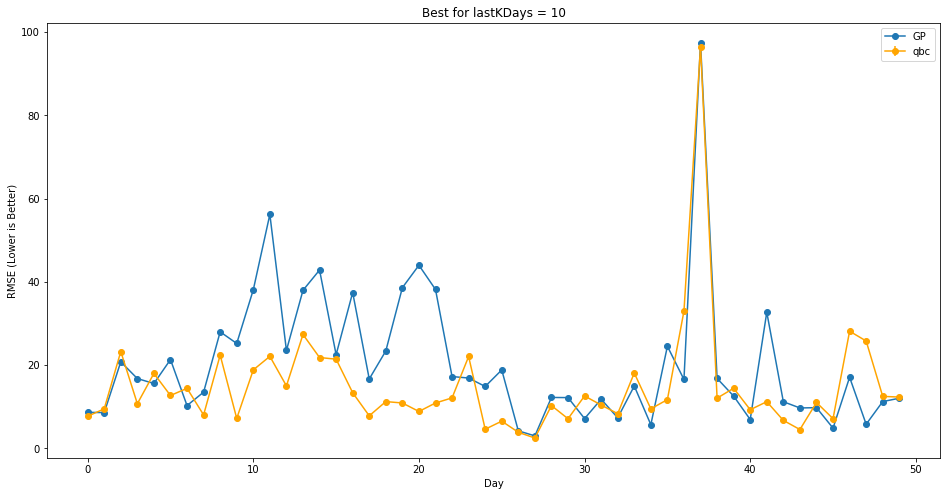

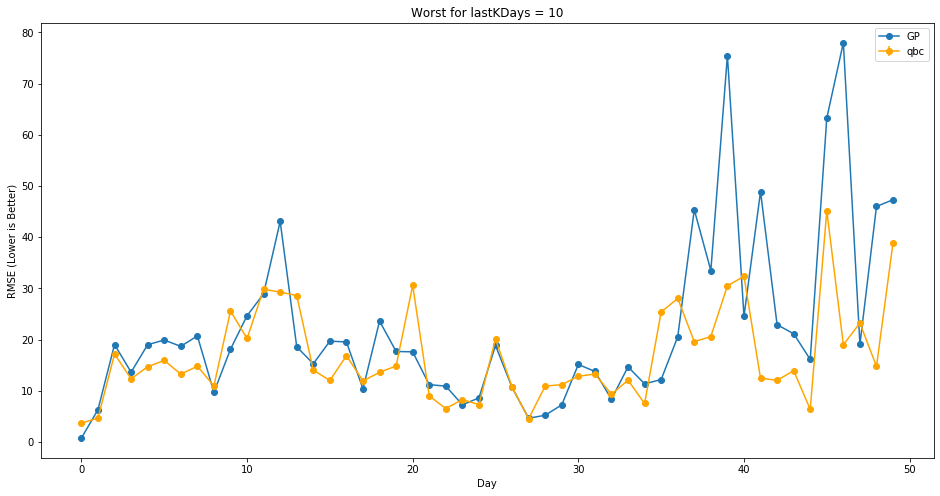

(0, 4) (2, 3)


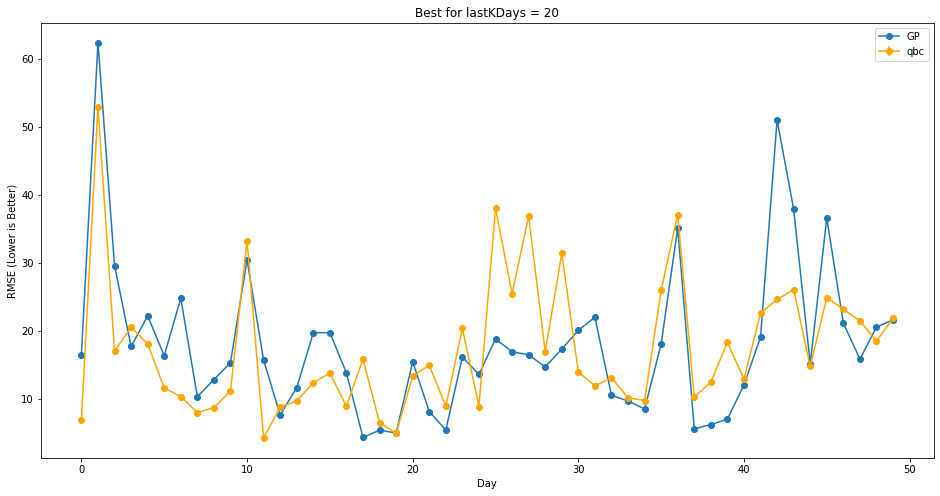

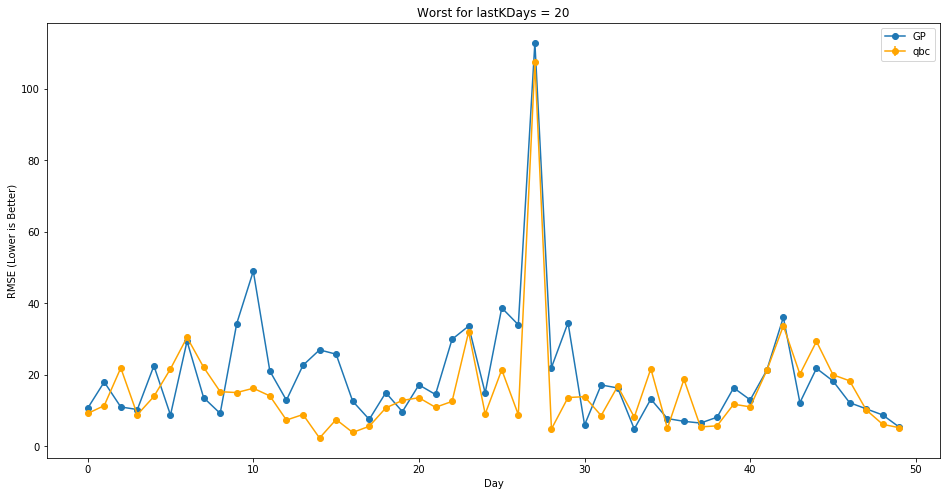

(0, 3) (1, 1)


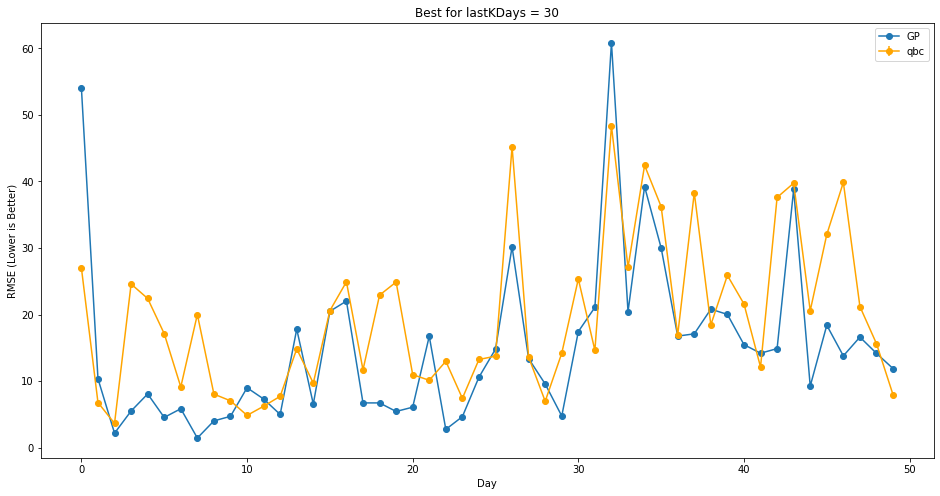

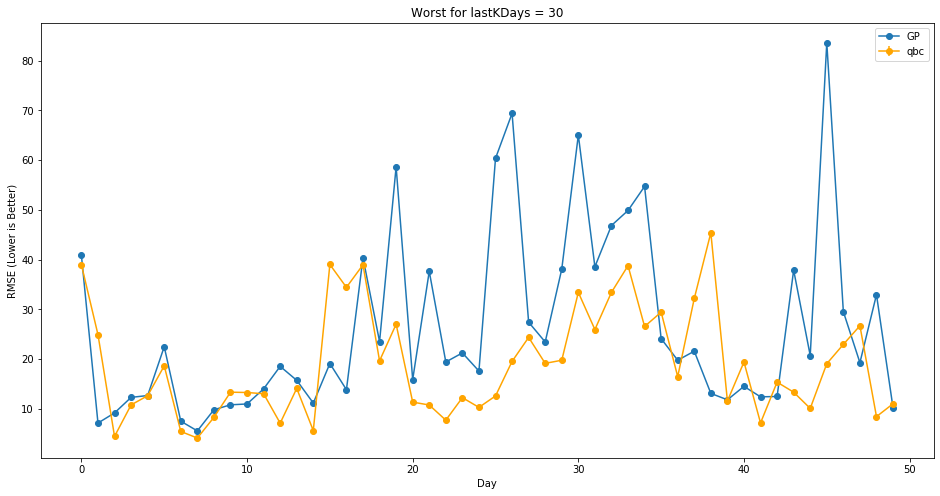

(0, 4) (1, 1)


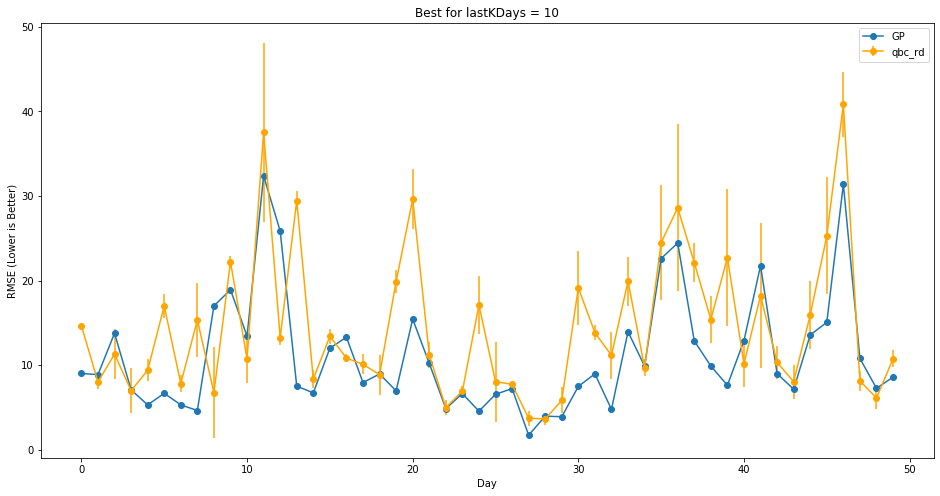

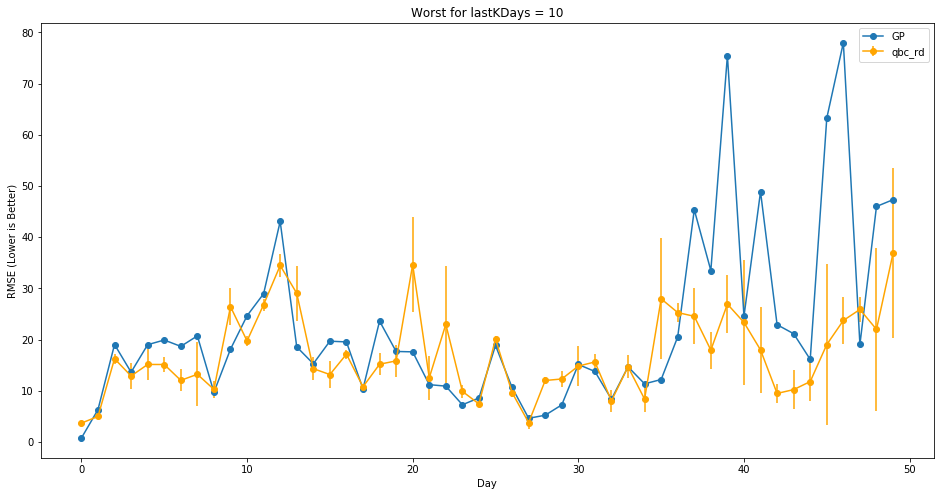

(0, 1) (5, 3)


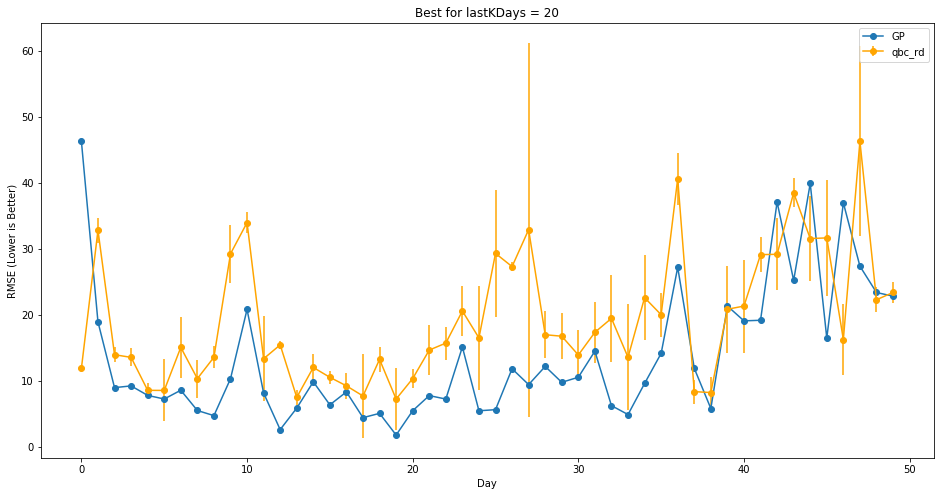

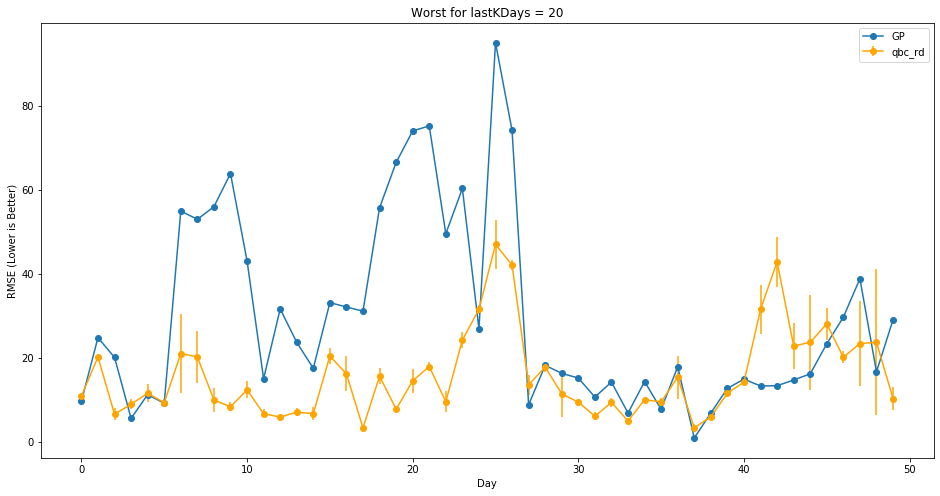

(0, 2) (5, 1)


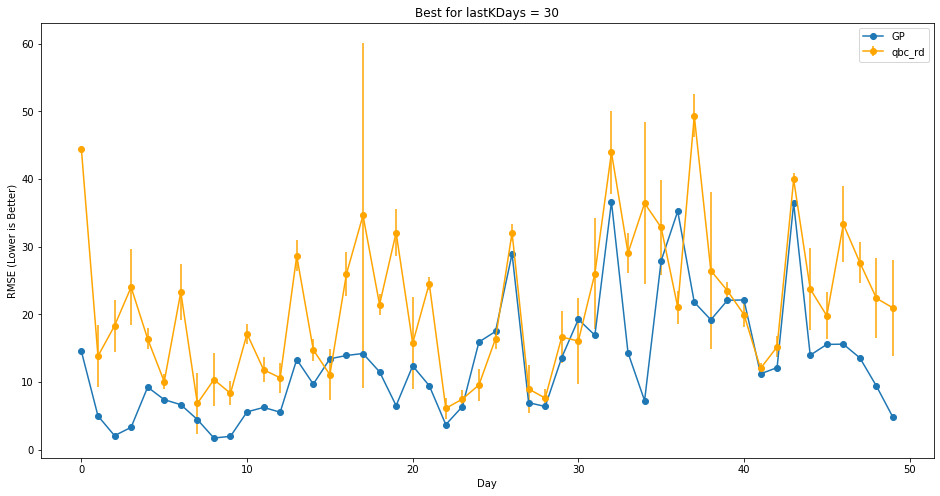

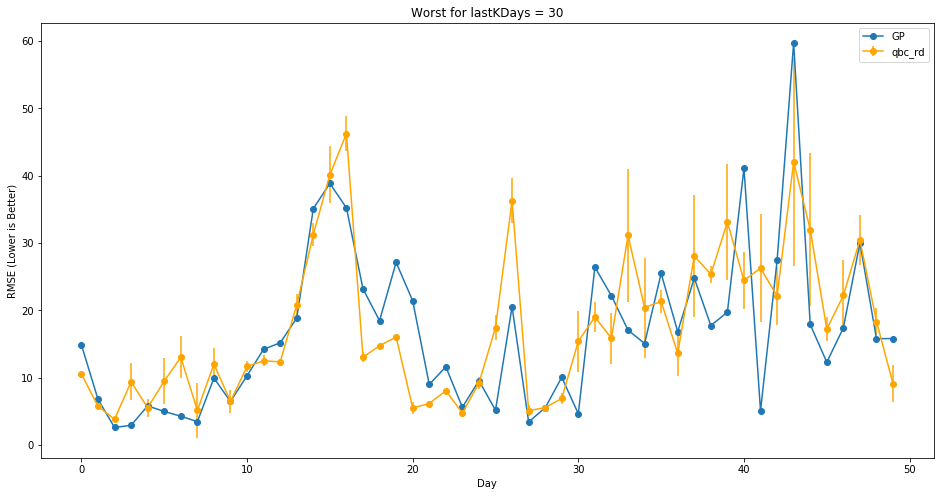

(2, 3) (3, 2)


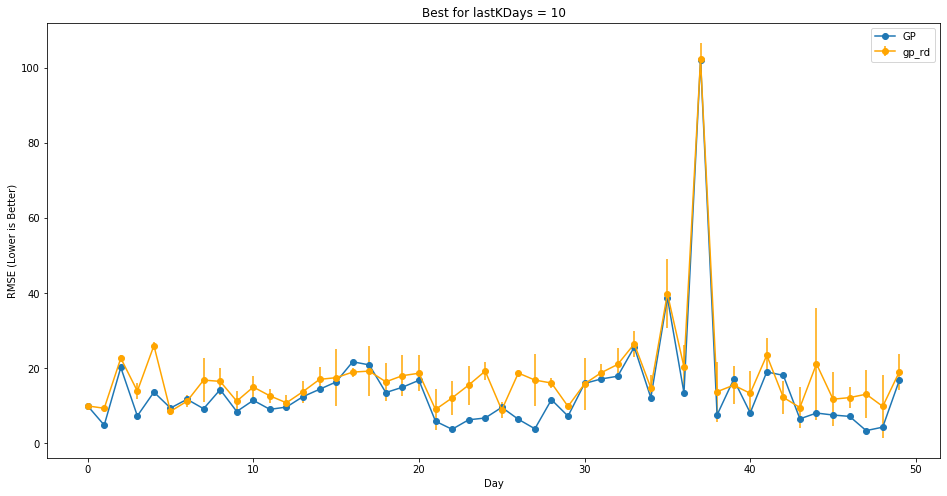

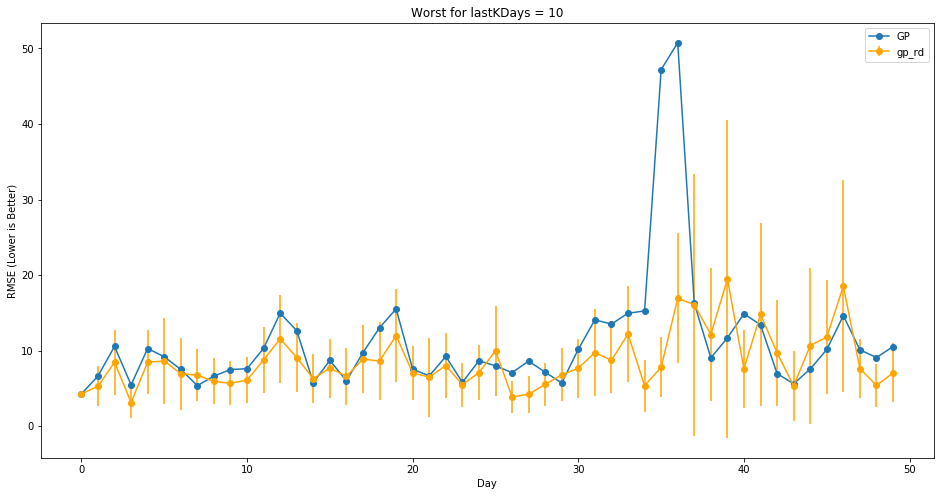

(1, 0) (5, 0)


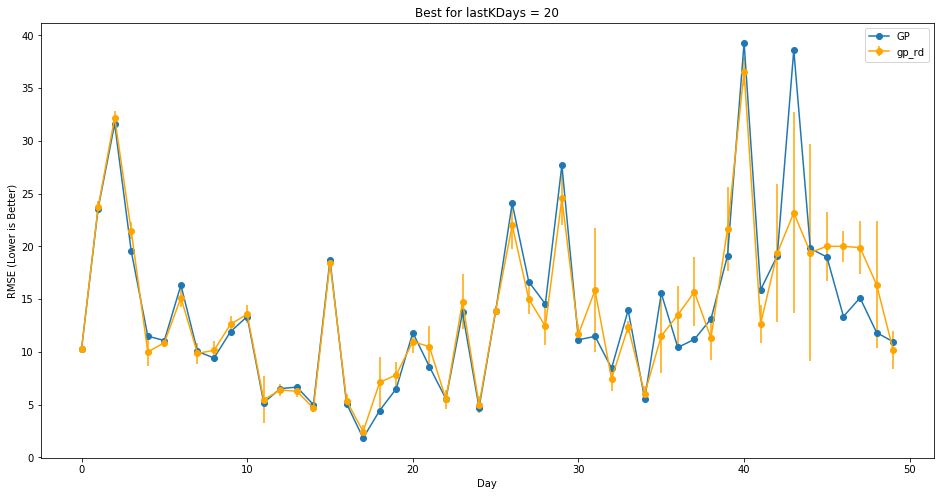

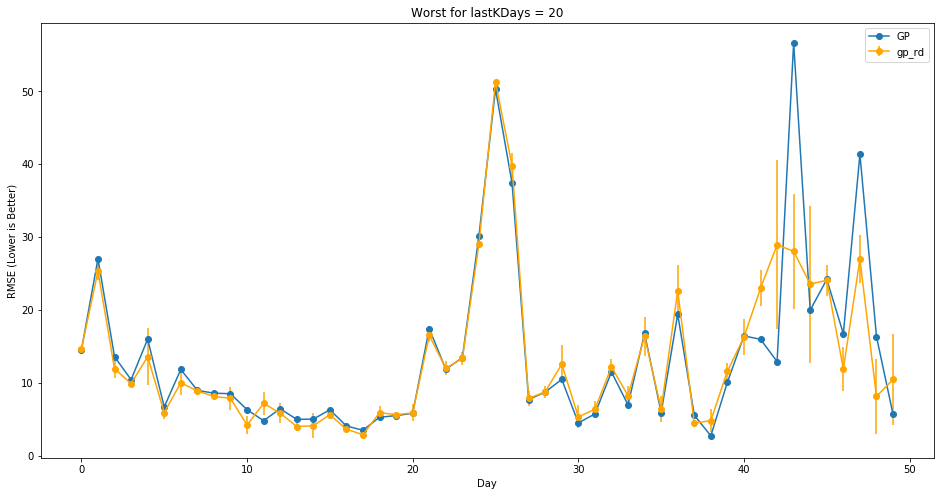

(0, 3) (0, 0)


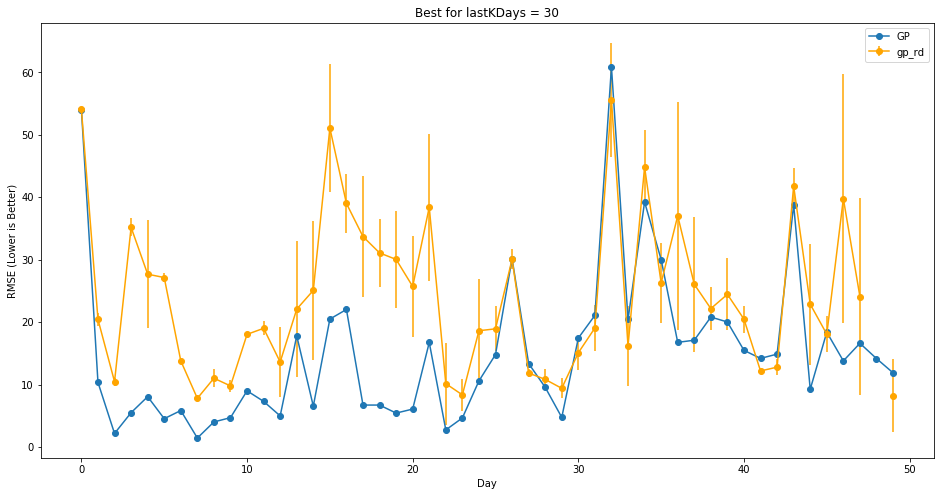

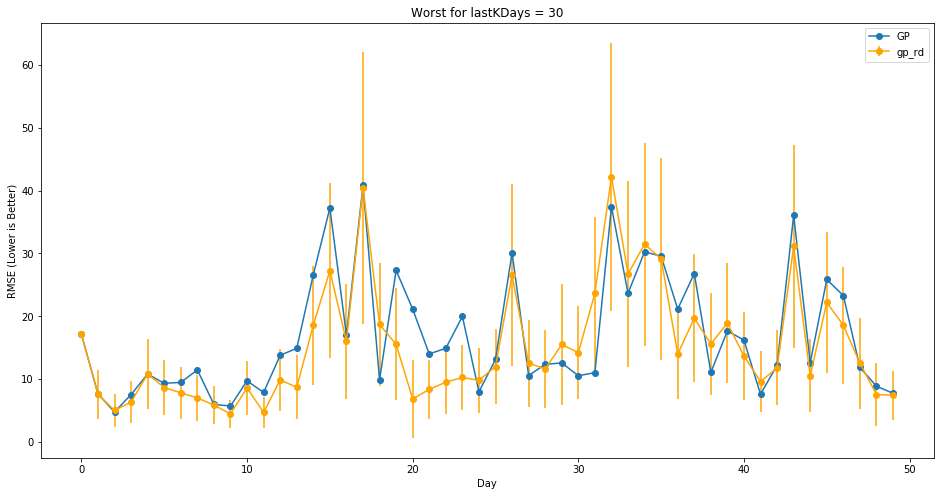

In [90]:
for comp in ["qbc", "qbc_rd", "gp_rd"]:
    for k, temp_df in win_loss_plots.groupby("lastKDays"):
        df = foo(k)
        hello = win_loss_plots[(win_loss_plots['comp']==comp) & (win_loss_plots['lastKDays']==k)]
        best_ix, worst_ix = hello[["best_ix", "worst_ix"]].values[0]
        print (best_ix, worst_ix)
        yoyo_df = df[(df['kout'] == best_ix[0]) & (df['kin'] == best_ix[1])]# contains comp and gp
#         break
        gp_mean = yoyo_df[yoyo_df["reg"] == 'gp']["rmse"].values[:50]
        comp_mean = yoyo_df[yoyo_df["reg"] == comp]["rmse"].values[:50]
        comp_std = yoyo_df[yoyo_df["reg"] == comp]["std"].values[:50]
        plt.figure(figsize=(16, 8))
        plt.plot(
            range(len(gp_mean)), 
            gp_mean, 
            label="GP",
            marker="o"
        )
        plt.errorbar(
            range(len(comp_mean)), 
            comp_mean, 
            yerr = comp_std, 
            label=comp, 
            c="orange", 
            ecolor='orange',
            marker="o",
        )
#         plt.errorbar(range(len(comp_std)), comp_std, c="orange")
        plt.title(f"Best for lastKDays = {k}")
        plt.ylabel("RMSE (Lower is Better)")
        plt.xlabel("Day")
        plt.legend()
        plt.show()
        yoyo_df = df[(df['kout'] == worst_ix[0]) & (df['kin'] == worst_ix[1])]
        gp_mean = yoyo_df[yoyo_df["reg"] == 'gp']["rmse"].values[:50]
        comp_mean = yoyo_df[yoyo_df["reg"] == comp]["rmse"].values[:50]
        comp_std = yoyo_df[yoyo_df["reg"] == comp]["std"].values[:50]
        plt.figure(figsize=(16, 8))
        plt.plot(
            range(len(gp_mean)),
            gp_mean, 
            label="GP",
            marker="o"
        )
        plt.errorbar(
            range(len(comp_mean)), 
            comp_mean, 
            yerr = comp_std, 
            label=comp, 
            c="orange", 
            ecolor='orange',
            marker="o",
        )
#         plt.errorbar(range(len(comp_std)), comp_std, c="orange")
        plt.title(f"Worst for lastKDays = {k}")
        plt.ylabel("RMSE (Lower is Better)")
        plt.xlabel("Day")
        plt.legend()
        plt.show()

In [65]:
hello[["best_ix", "worst_ix"]].values[0]

array([(2, 3), (3, 2)], dtype=object)

In [ ]:
new_dic = {'gp': 5560, 'gp_rd': 2380, 'qbc': 2669, 'qbc_rd': 11}

In [183]:
old_dic = {'gp': 5734, 'gp_rd': 1820, 'qbc_rd': 835, 'qbc': 2291}

In [171]:
[print (f"{dic['gp']}/{v}") for k, v in dic.items() if k != 'gp']
dic{'gp'} / sum([])

5734/1820
5734/835
5734/2291


[None, None, None]

In [160]:
tempdf2["rmse"]

reg
gp        19.469334
gp_rd     17.834976
qbc       21.665664
qbc_rd    20.758282
Name: rmse, dtype: float64

In [127]:
# for i in range(6):
#     for j in range(5):
#         tmp = df[df['i']==i]
#         tmp = tmp[tmp['j']==j]
# #         sns.lineplot(data=tmp, x="X", y="Y", hue="reg")
#         print (tmp.groupby("reg").mean())
# #         plt.show()

In [128]:
df.groupby("reg").mean()

,kout,kin,X,rmse,std
reg,,,,,
gp,2.5,2.0,172.596339,20.350975,0.000000
gp_rd,2.5,2.0,172.596339,23.373950,8.727330
qbc,2.5,2.0,172.596339,22.814577,0.000000
qbc_rd,2.5,2.0,172.596339,24.066029,6.467782


In [172]:
gp = np.load("../exp2/src/results/20/final_gp/0_0/final_rmse.npy")
qbc = np.load("../exp2/src/results/20/final_qbc/0_0/final_rmse.npy")
qbc_rd = np.load("../exp2/src/results/20/final_random_qbc/0_0/final_rmse.npy")[:5].mean(axis=0)
gp_rd = np.load("../exp2/src/results/20/final_random_gp/0_0/final_rmse.npy").mean(axis=0)


In [29]:
for i in range(6):
    for j in range(5):
        qbc_rd = np.load(f"../exp2/src/results/20/final_random_qbc/{i}_{j}/final_rmse.npy")[:5].mean(axis=0)
        print (qbc_rd.shape)

(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)
(346,)


(346,)

In [ ]:
gp = gp[gp!=0]
qbc = qbc[qbc!=0]

In [81]:
gp[1], gp_rd[1], qbc[0], qbc_rd[0] 

(22.367600909296137,
 19.846230717294098,
 7.1551148292844955,
 7.1551148292844955)

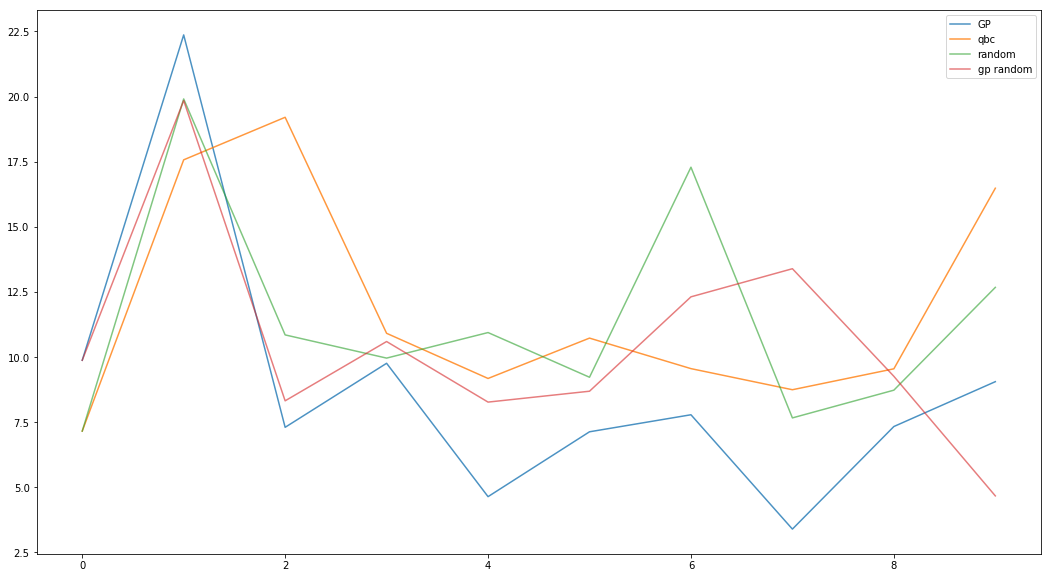

In [82]:
plt.figure(figsize=(18, 10))
plt.plot(gp[:10], alpha= 0.8, label="GP")
plt.plot(qbc[:10], alpha = 0.8, label="qbc")
plt.plot(qbc_rd[:10], alpha = 0.6, label='random')
plt.plot(gp_rd[:10], alpha = 0.6, label='gp random')

plt.legend()
# plt.plot(qbc_rd)

In [6]:
np.load("../exp2/src/results/20/final_gp/0_0/final_rmse.npy")
gp.mean(), qbc.mean()

(16.87702705582097, 21.959137708694254)

In [16]:
mean = qbc_rd.mean(axis = 0)
mean = mean[mean!=0]

In [ ]:
    for j in range(1,31,5):
        plt.axvline(j,ls='--',color='k',lw=0.5)
#     format_axes(plt.gca())
#     plt.errorbar([i for i in range(32)],random_final,yerr=stddev,marker='.',label='Random Sampling')


In [29]:
gp.shape

(346,)